In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm.notebook import tqdm

import torch
import torchvision
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
from torchvision.utils import make_grid

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
SEED = 17
seed_everything(SEED)

# Data Folder

In [6]:
data_dir = '../input/cassava-leaf-disease-classification'
train_dir = data_dir + '/train_images'
train_csv = data_dir + '/train.csv'
test_dir = data_dir + '/test_images'
name_json = data_dir + '/label_num_to_disease_map.json'
sample_csv = data_dir + '/sample_submission.csv'

# Read CSV

In [7]:
train_df = pd.read_csv(train_csv)
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [8]:
train_df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

the dataset seems heavily unbalanced towards label 3.

In [9]:
sub_df = pd.read_csv(sample_csv)
sub_df.head()

,image_id,label
0,2216849948.jpg,4


# Dataset

In [10]:
class CassavaDS(Dataset):
    def __init__(self, df, data_dir, transforms=None):
        super().__init__()
        self.df_data = df.values
        self.transforms = transforms
        self.data_dir = data_dir

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            image = self.transforms(img)
        return image, label

In [11]:
X_train, X_valid = train_test_split(train_df, test_size=0.1, 
                                                    random_state=SEED,
                                                    stratify=train_df.label.values)

In [12]:
X_train.shape, X_valid.shape

((19257, 2), (2140, 2))

In [13]:
normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [14]:
train_tf = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomRotation(90),
    transforms.RandomAffine(10),
    transforms.ColorJitter(brightness=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    normalize
])

valid_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [15]:
train_ds = CassavaDS(X_train, train_dir, train_tf)
valid_ds = CassavaDS(X_valid, train_dir, valid_tf)

In [16]:
bs = 64

In [17]:
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=bs, shuffle=True)

# Labels

In [18]:
import json

with open(name_json, 'r') as f:
    cat_to_name = json.load(f)

In [19]:
cat_to_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

# Plot Images

In [20]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [21]:
unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [22]:
def display_img(img, label=None, unnorm_obj=None, invert=True, return_label=True):
    if unnorm_obj != None:
        img = unnorm_obj(img)

    plt.imshow(img.permute(1, 2, 0))
    
    if label != None:
        plt.title(cat_to_name[str(label)])

In [23]:
def display_batch(batch, unnorm_obj=None):    
    imgs, labels = batch
    
    if unnorm_obj:
        unnorm_imgs = []
        for img in imgs:
            unnorm_imgs.append(unnorm_obj(img))
        imgs = unnorm_imgs
    
    ig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(imgs, nrow=16).permute(1, 2, 0))

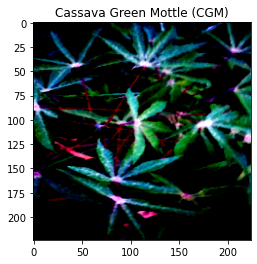

In [24]:
img, label = train_ds[0]
display_img(img, label)

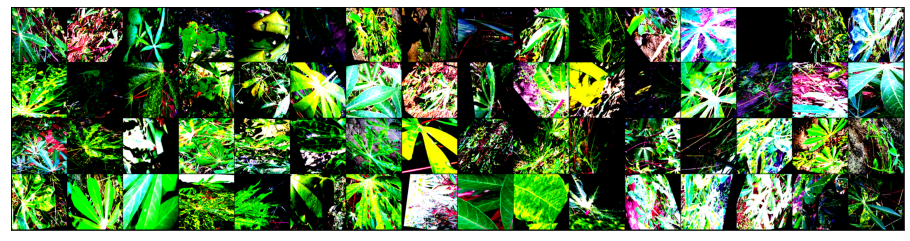

In [25]:
display_batch(next(iter(train_loader)))

# Helper Functions

In [26]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

In [27]:
def save_checkpoint(model, is_best, filename='./checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

In [28]:
def load_checkpoint(model, filename = './checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

In [29]:
def prec_recall_fscore(input, targs):
    scores = precision_recall_fscore_support(targs.cpu(), input.cpu(), average='macro')
    return {'precision': scores[0], 'recall': scores[1], 'fscore': scores[2], 'support': scores[3]} # return dictionary of 4 values

def print_prec_recall_fscore(scores):
    print("Precision Recall FScores Metric:")
    print(scores)
    
    return scores

# Train and Test

In [30]:
def train(loader, model, optimizer, device):
    model.train()
    correct, trn_loss, trn_time = 0., 0., 0
    t = tqdm(loader, leave=False, total=len(loader))
    bt_start = time.time()
    for i, (ip, target) in enumerate(t):
        ip, target = ip.to(device), target.to(device)                          
        output = model(ip)
        loss = criterion(output, target)
        trn_loss += loss.item()
        
        # measure accuracy and record loss
        _, pred = output.max(dim=1)
        correct += torch.sum(pred == target.data)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    trn_time = time.time() - bt_start
    trn_acc = correct * 100 / len(loader.dataset)
    trn_loss /= len(loader)
    print_prec_recall_fscore(prec_recall_fscore(pred, target))
    return trn_acc, trn_loss, trn_time

In [31]:
def valid(loader, model, optimizer, device):
    model.eval()
    with torch.no_grad():
        correct, val_loss, val_time = 0., 0., 0
        t = tqdm(loader, leave=False, total=len(loader))
        bt_start = time.time()
        for i, (ip, target) in enumerate(t):
            ip, target = ip.to(device), target.to(device)                          
            output = model(ip)
            loss = criterion(output, target)
            val_loss += loss.item()

            # measure accuracy and record loss
            _, pred = output.max(dim=1)
            correct += torch.sum(pred == target.data)

        val_time = time.time() - bt_start
        val_acc = correct * 100 / len(loader.dataset)
        val_loss /= len(loader)
        print_prec_recall_fscore(prec_recall_fscore(pred, target))
        return val_acc, val_loss, val_time

In [32]:
def fit(model, sched, optimizer, device, epoch):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    best_acc = 0.
    for j in range(epoch):
        trn_acc, trn_loss, trn_time = train(train_loader, model, optimizer, device)
        trn_stat.append(trn_loss, trn_acc, trn_time)
        val_acc, val_loss, val_time = valid(valid_loader, model, optimizer, device)
        val_stat.append(val_acc, val_loss, val_time)
        if sched:
            sched.step()
        if val_acc > best_acc:
            best_acc = val_acc
            save_checkpoint(model, True, './best_model.pth')
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_loss, val_loss, trn_acc, val_acc))

# Vision Transformer

Using implementation from https://github.com/nachiket273/Vision_transformer_pytorch.git

Using weights from pretrained-model on Imagenet-1k <br>
File is available at https://www.kaggle.com/nachiket273/visiontransformerpretrainedimagenet1kweights

pytorch tpu kernel available @ https://www.kaggle.com/nachiket273/pytorch-tpu-vision-transformer

In [33]:
!cp ../input/visiontransformerpretrainedimagenet1kweights/vit.py .
!cp ../input/visiontransformerpretrainedimagenet1kweights/vit_16_224_imagenet1000.pth .

In [34]:
from vit import ViT

In [35]:
def get_model(out_features=5):
    model = ViT(224, 16, drop_rate=0.1)
    load_checkpoint(model, './vit_16_224_imagenet1000.pth')
    model.out = nn.Linear(in_features=model.out.in_features, out_features=5)
    for param in model.parameters():
        param.require_grad = True
    return model

In [36]:
model = get_model()

In [37]:
model = model.to(device)

In [38]:
trn_stat = AvgStats()
val_stat = AvgStats()

In [39]:
criterion = nn.CrossEntropyLoss()

In [40]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

In [41]:
epochs = 20

In [42]:
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-3)

In [43]:
fit(model, sched, optimizer, device, epochs)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc


Precision Recall FScores Metric:
{'precision': 0.679047619047619, 'recall': 0.5971428571428572, 'fscore': 0.5616361416361417, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.5916666666666666, 'recall': 0.6184615384615385, 'fscore': 0.5825252525252524, 'support': None}
1	0.73385478	0.65512166	73.41226196	75.70093536


Precision Recall FScores Metric:
{'precision': 0.8171428571428571, 'recall': 0.6772922502334267, 'fscore': 0.6810435178856232, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.85, 'recall': 0.55, 'fscore': 0.5813852813852813, 'support': None}
2	0.60172816	0.53286524	78.06511688	80.79439545


Precision Recall FScores Metric:
{'precision': 0.7173529411764705, 'recall': 0.6813690476190477, 'fscore': 0.6838095238095238, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.775, 'recall': 0.6866666666666666, 'fscore': 0.7224633431085044, 'support': None}
3	0.56432109	0.50059515	79.53990936	82.47663879


Precision Recall FScores Metric:
{'precision': 0.8994871794871795, 'recall': 0.825873015873016, 'fscore': 0.8323931623931624, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.3712820512820513, 'recall': 0.41117647058823525, 'fscore': 0.37230769230769234, 'support': None}
4	0.54689590	0.60297980	80.46424866	78.13084412


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Recall FScores Metric:
{'precision': 0.5177777777777777, 'recall': 0.5038095238095237, 'fscore': 0.48993979200875765, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8208333333333334, 'recall': 0.7886904761904762, 'fscore': 0.7067073170731707, 'support': None}
5	0.52808442	0.48353005	80.91083527	82.57009888


Precision Recall FScores Metric:
{'precision': 0.6727106227106228, 'recall': 0.611023166023166, 'fscore': 0.6370927318295739, 'support': None}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Recall FScores Metric:
{'precision': 0.8194444444444443, 'recall': 0.7361111111111112, 'fscore': 0.7277777777777776, 'support': None}
6	0.51515549	0.46580712	81.84037018	83.59813690


Precision Recall FScores Metric:
{'precision': 0.8516666666666668, 'recall': 0.8488888888888889, 'fscore': 0.8130624930624931, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.5311111111111112, 'recall': 0.5104761904761904, 'fscore': 0.42828282828282827, 'support': None}
7	0.49595345	0.54861350	82.45313263	80.37383270


Precision Recall FScores Metric:
{'precision': 0.7830158730158729, 'recall': 0.7742105263157895, 'fscore': 0.7392324792324791, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8333333333333334, 'recall': 0.78, 'fscore': 0.7132832080200501, 'support': None}
8	0.48473658	0.46792818	82.64527130	83.41121674


Precision Recall FScores Metric:
{'precision': 0.7043073593073593, 'recall': 0.69375, 'fscore': 0.6955311355311355, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.9375, 'recall': 0.9875, 'fscore': 0.9578754578754579, 'support': None}
9	0.46489537	0.44035898	83.42939758	84.57944489


Precision Recall FScores Metric:
{'precision': 0.6855311355311355, 'recall': 0.5903679653679654, 'fscore': 0.6082972582972583, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.5355555555555556, 'recall': 0.612280701754386, 'fscore': 0.517117117117117, 'support': None}
10	0.45099404	0.47939098	83.84483337	83.69158936


Precision Recall FScores Metric:
{'precision': 0.6992857142857142, 'recall': 0.6490225563909775, 'fscore': 0.6574203574203574, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6205128205128204, 'recall': 0.667142857142857, 'fscore': 0.5993675889328063, 'support': None}
11	0.44444555	0.46891717	84.27584839	84.11215210


Precision Recall FScores Metric:
{'precision': 0.8091891891891893, 'recall': 0.812046332046332, 'fscore': 0.8084898884898883, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6951754385964912, 'recall': 0.725, 'fscore': 0.706959706959707, 'support': None}
12	0.43707625	0.46339406	84.39528656	84.20561218


Precision Recall FScores Metric:
{'precision': 0.5520242914979757, 'recall': 0.542439431913116, 'fscore': 0.5334928229665072, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7, 'recall': 0.6866666666666668, 'fscore': 0.654055829228243, 'support': None}
13	0.42248204	0.45120258	85.12229156	84.11215210


Precision Recall FScores Metric:
{'precision': 0.9384126984126983, 'recall': 0.8287878787878787, 'fscore': 0.8658944001795534, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7, 'recall': 0.8511904761904762, 'fscore': 0.7513888888888889, 'support': None}
14	0.41409682	0.47216525	85.17422485	84.11215210


Precision Recall FScores Metric:
{'precision': 0.73875, 'recall': 0.7804166666666668, 'fscore': 0.7399404761904761, 'support': None}


Precision Recall FScores Metric:
{'precision': 1.0, 'recall': 1.0, 'fscore': 1.0, 'support': None}
15	0.40540022	0.50717927	85.37155151	82.66355133


Precision Recall FScores Metric:
{'precision': 0.7776190476190477, 'recall': 0.7428571428571429, 'fscore': 0.748154948499776, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.6166666666666667, 'recall': 0.8529411764705882, 'fscore': 0.6599999999999999, 'support': None}
16	0.39108091	0.51894950	86.05701447	82.52336884


Precision Recall FScores Metric:
{'precision': 0.6452991452991452, 'recall': 0.6053968253968254, 'fscore': 0.6112895555149077, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.7333333333333333, 'recall': 0.8, 'fscore': 0.76, 'support': None}
17	0.38515451	0.47716531	86.45687103	84.01869202


Precision Recall FScores Metric:
{'precision': 0.7627403062886934, 'recall': 0.8471847507331379, 'fscore': 0.7878865051191027, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8017543859649123, 'recall': 0.7466666666666666, 'fscore': 0.7361904761904762, 'support': None}
18	0.37614381	0.53502222	86.86191559	82.47663879


Precision Recall FScores Metric:
{'precision': 0.9144444444444444, 'recall': 0.9269669669669671, 'fscore': 0.9157574301049427, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.5722222222222222, 'recall': 0.5619047619047619, 'fscore': 0.5648351648351648, 'support': None}
19	0.37169283	0.59355849	86.91904449	80.18692017


Precision Recall FScores Metric:
{'precision': 0.5977777777777777, 'recall': 0.5878362573099415, 'fscore': 0.54993762993763, 'support': None}


Precision Recall FScores Metric:
{'precision': 0.8894736842105264, 'recall': 0.8933333333333333, 'fscore': 0.8657057057057058, 'support': None}
20	0.36848760	0.53181360	87.13195038	81.77570343


# Predict

In [44]:
test_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [45]:
load_checkpoint(model, './best_model.pth')

In [46]:
def predict(test_dir, model, device):
    img_names = []
    preds = []
    for name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, name)
        img = Image.open(img_path).convert("RGB")
        img = test_tf(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        op = model(img)
        _, pred = op.max(dim=1)
        img_names.append(name)
        preds.append(pred.item())
    return img_names, preds

In [47]:
img_names, preds = predict(test_dir, model, device)

In [48]:
img_names, preds

(['2216849948.jpg'], [3])

In [49]:
sub_df.head()

,image_id,label
0,2216849948.jpg,4


In [50]:
sub_df['image_id'] = img_names
sub_df['label'] = preds

In [51]:
sub_df.head()

,image_id,label
0,2216849948.jpg,3


In [52]:
sub_df.to_csv('submission.csv', index=False)